# COMP90051 Project 2

In [152]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [153]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [154]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        if (narms<1):
            raise ValueError("Arms are too less!")
        if (epsilon>1 or epsilon<0):
            raise ValueError("Probability should be in 0-1")
        self.narms = int(narms)
        self.K = np.zeros(self.narms)
        self.epsilon = epsilon
        self.est_value = np.full(self.narms,Q0)
        self.tot_reward = np.zeros(self.narms)
        
    def play(self, tround, context=None):
        rand_num = np.random.random()
        if self.epsilon > rand_num:
            return np.random.randint(self.narms)
        else:
            # Tie break among eligible max values
            return np.random.choice(np.flatnonzero(self.est_value == self.est_value.max()))        
        
    def update(self, arm, reward, context=None):
        self.K[arm] += 1
        self.tot_reward[arm] += reward
        if self.est_value[arm] != np.inf:
            self.est_value[arm] = self.tot_reward[arm] / self.K[arm]
        else:
            self.est_value[arm] = self.tot_reward[arm] / self.K[arm]

In [155]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        if (narms<1):
            raise ValueError("Arms are too less!")
        if (rho <= 0):
            raise ValueError("Rho should be a positive value")
        self.narms = int(narms)
        self.K = np.zeros( self.narms)
        self.rho = rho
        self.est_value = np.full( self.narms,Q0)
        self.ucb = np.zeros( self.narms)
        self.tot_reward = np.zeros( self.narms)
        
    def play(self, tround, context=None):
        self.tround = tround
        # Tie break among eligible max values           
        return  np.random.choice(np.flatnonzero(self.est_value == self.est_value.max()))        
        
        
    def update(self, arm, reward, context=None):
        self.K[arm] += 1
        self.tot_reward[arm] += reward
        self.ucb[arm] = np.sqrt((self.rho * np.log(self.tround))/self.K[arm])

        if self.est_value[arm] != np.inf:
            self.est_value[arm] = self.ucb[arm] + (self.tot_reward[arm]/self.K[arm])
        else:
            self.est_value[arm] = self.ucb[arm] + (self.tot_reward[arm] / self.K[arm])

        
    

## 2. The Basic Thompson Bandit

In [156]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        if (narms<1):
            raise ValueError("Arms are too less!")
        if (alpha0 <= 0):
            raise ValueError("alpha0 should be positive")
        if (beta0 <= 0):
            raise ValueError("beta0 should be positive")
        self.narms = int(narms)
        self.S_arm = np.full(self.narms,alpha0)
        self.F_arm = np.full(self.narms,beta0)
        self.est_value = np.zeros(self.narms)
        for i in range(self.narms):
            self.est_value[i] = np.random.beta(self.S_arm[i] + 1,self.F_arm[i] + 1)
    
    def play(self, tround, context=None):
        # Tie break among eligible max values
        return np.random.choice(np.flatnonzero(self.est_value == self.est_value.max()))        
        
    def update(self, arm, reward, context=None):
        if reward == 1:
            self.S_arm[arm] += 1
        else:
            self.F_arm[arm] += 1
        self.est_value[arm] = np.random.beta((self.S_arm[arm] + 1),(self.F_arm[arm] + 1))
            

## 3. Off-Policy Evaluation

In [157]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    T = len(arms) #Storing the length of the events ( total number of rows in the dataset file)
    history = []
    for t in range(T):
        if (nrounds!= None and len(history) > nrounds):
            break
        action = mab.play(len(history)+1,contexts[t])
        if(action==arms[t]-1):
            mab.update(action,rewards[t],contexts[t])
            history.append(rewards[t])
    out = np.array(history)
    return out


In [158]:
###
## Reading files
###
def readData(fileName):
    with open(fileName,'r') as f:
        dataset =[x.strip().split(' ') for x in f]
    n = len(dataset)
    arms = np.zeros(n)
    rewards = np.zeros(n)
    contexts = []
    for i, data in enumerate(dataset):
        arms[i] = data[0]
        rewards[i] = data[1]
        contexts.append(data[2:])
    context_arr = np.array(contexts)
    return arms,rewards,context_arr

arms,rewards,contexts = readData('dataset.txt')

In [174]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts,800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.15730337078651685


In [175]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17228464419475656


In [177]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.26591760299625467


## 4. Contextual Bandits - LinUCB

In [162]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        if (narms<1):
            raise ValueError("Arms are too less!")
        if (ndims<1):
            raise ValueError("Dimension are too less!")
        if (alpha <= 0):
            raise ValueError("Alpha should be positive real number")
        self.narms = int(narms)
        self.ndims = int(ndims)
        self.A_a = []
        self.b_a = []
        self.x_t_a = []
        for i in range(self.narms):
            self.A_a.append(np.eye(self.ndims))
            self.b_a.append(np.zeros(self.ndims))
            self.x_t_a.append(np.zeros(self.ndims))
        self.A_a = np.array(self.A_a)
        self.b_a = np.array(self.b_a)
        self.x_t_a = np.array(self.x_t_a)
        self.alpha = alpha
        
    
    def play(self, tround, context):
        est_value = np.zeros(self.narms)
        for arm in range(self.narms):
            self.x_t_a[arm] = context[self.ndims * arm: (self.ndims * arm) + self.ndims]
            self.x_t_a[arm] = np.array(self.x_t_a[arm], dtype='float64')
            theta_cap_a = np.linalg.inv(self.A_a[arm]) @ self.b_a[arm]
            est_value[arm] = theta_cap_a.T @ self.x_t_a[arm] + (self.alpha * np.sqrt(self.x_t_a[arm].T @ np.linalg.inv(self.A_a[arm]) @ self.x_t_a[arm]))
        return np.random.choice(np.flatnonzero(est_value == est_value.max()))    
        
    def update(self, arm, reward, context):
        self.A_a[arm] = self.A_a[arm] + self.x_t_a[arm] @ self.x_t_a[arm].T
        self.b_a[arm] = self.b_a[arm] + reward * self.x_t_a[arm]

In [163]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2671660424469413


## 5. Contextual Bandits - LinThompson

In [164]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        if (narms<1):
            raise ValueError("Arms are too less!")
        if (ndims<1):
            raise ValueError("Dimension are too less!")
        self.narms = int(narms)
        self.ndims = int(ndims)
        self.B = np.eye(self.narms)
        self.mu_cap = np.zeros(self.narms)
        self.f = np.zeros(self.narms)
        self.v = v
        
        
    def play(self, tround, context):
        if(self.narms*self.ndims != len(context)):
            raise ValueError("Dimension mismatch")
        B_inv = np.linalg.inv(self.B)
        mu_hat_t = np.random.multivariate_normal(self.mu_cap, np.dot(np.square(self.v), B_inv))
        b_i_t = np.reshape(context,(self.narms,self.ndims))
        b_i_t = np.array(b_i_t, dtype='float64')
        est_value = b_i_t @ mu_hat_t
        return np.random.choice(np.flatnonzero(est_value == est_value.max()))    

    
    def update(self, arm, reward, context):
        b_a_t = context[self.ndims * arm : (self.ndims * arm) + self.ndims]
        b_a_t = np.array(b_a_t, dtype='float64')
        self.B += b_a_t @ b_a_t.T
        self.f += np.dot(b_a_t,reward)
        B_inv_new = np.linalg.inv(self.B)
        self.mu_cap = B_inv_new @ self.f 

    

In [165]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.3433208489388265


## 6. Evaluation
### 6.A.

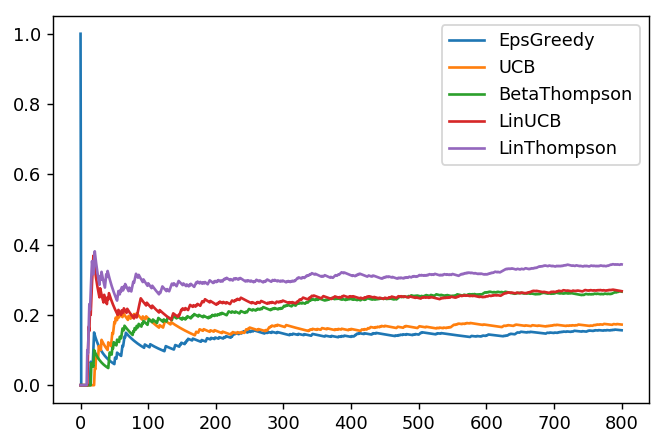

In [178]:
def getCumSum(results):
    cresults = np.zeros(len(results))
    cresults[0] = results[0]
    for i in range(len(results)-1):
        cresults[i+1] = (cresults[i] * i + results[i+1])/(i+1)
    return cresults

cresults_EpsGreedy = getCumSum(results_EpsGreedy)
cresults_UCB = getCumSum(results_UCB)
cresults_BetaThompson = getCumSum(results_BetaThompson)
cresults_LinUCB = getCumSum(results_LinUCB)
cresults_LinThompson = getCumSum(results_LinThompson)
    
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
plt.plot(range(len(cresults_EpsGreedy)), cresults_EpsGreedy,label='EpsGreedy')
plt.plot(range(len(cresults_UCB)), cresults_UCB,label='UCB')
plt.plot(range(len(cresults_BetaThompson)), cresults_BetaThompson,label='BetaThompson')
plt.plot(range(len(cresults_LinUCB)), cresults_LinUCB,label='LinUCB')
plt.plot(range(len(cresults_LinThompson)), cresults_LinThompson,label='LinThompson')

plt.legend()
plt.show()

### 6.B.

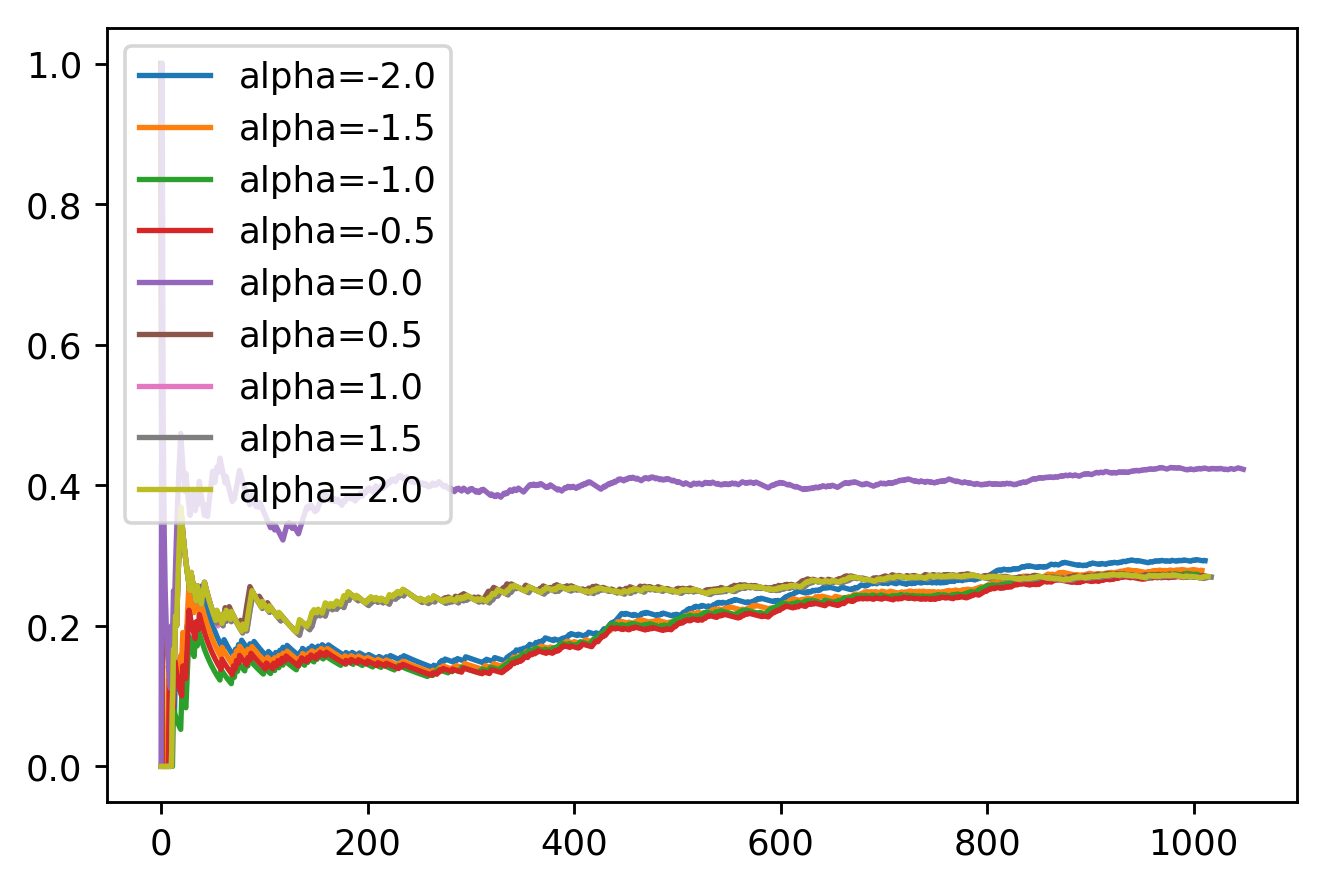

'\nOverall the graphs indicate that for values of \n    alpha > 1, the linUCB algorithms behaves similar and better\n    alpha < 1, linUCB behaves bad\n    alpha < 0, for alpha close to -2 the algorithm behvaes better initially but poor later on. \n'

In [93]:
"""
One of the ways to optimise hyper parameters is by grid-search based method
"""
FIGURE_RESOLUTION = 256
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
for alpha in np.arange(-2,2.1,0.5):
    mab = LinUCB(10, 10, alpha)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 8000)
    cresults_LinUCB = np.zeros(len(results_LinUCB))
    cresults_LinUCB[0] = results_LinUCB[0]
    for i in range(len(results_LinUCB)-1):
        cresults_LinUCB[i+1] = (cresults_LinUCB[i] * i + results_LinUCB[i+1])/(i+1)
    plt.plot(range(len(results_LinUCB)), cresults_LinUCB,label='alpha='+str(alpha))

plt.legend()
plt.show()

"""
Overall the graphs indicate that for values of 
    alpha = 0, performs best but in the paper, the way alpha is defined, it is always greater than 1, so this behaviour
    of alpha is deviating from the theory. It however means that on reaching 800 iterations, the true value of the parameters
    reaches and the estimated value matches the true value.
"""

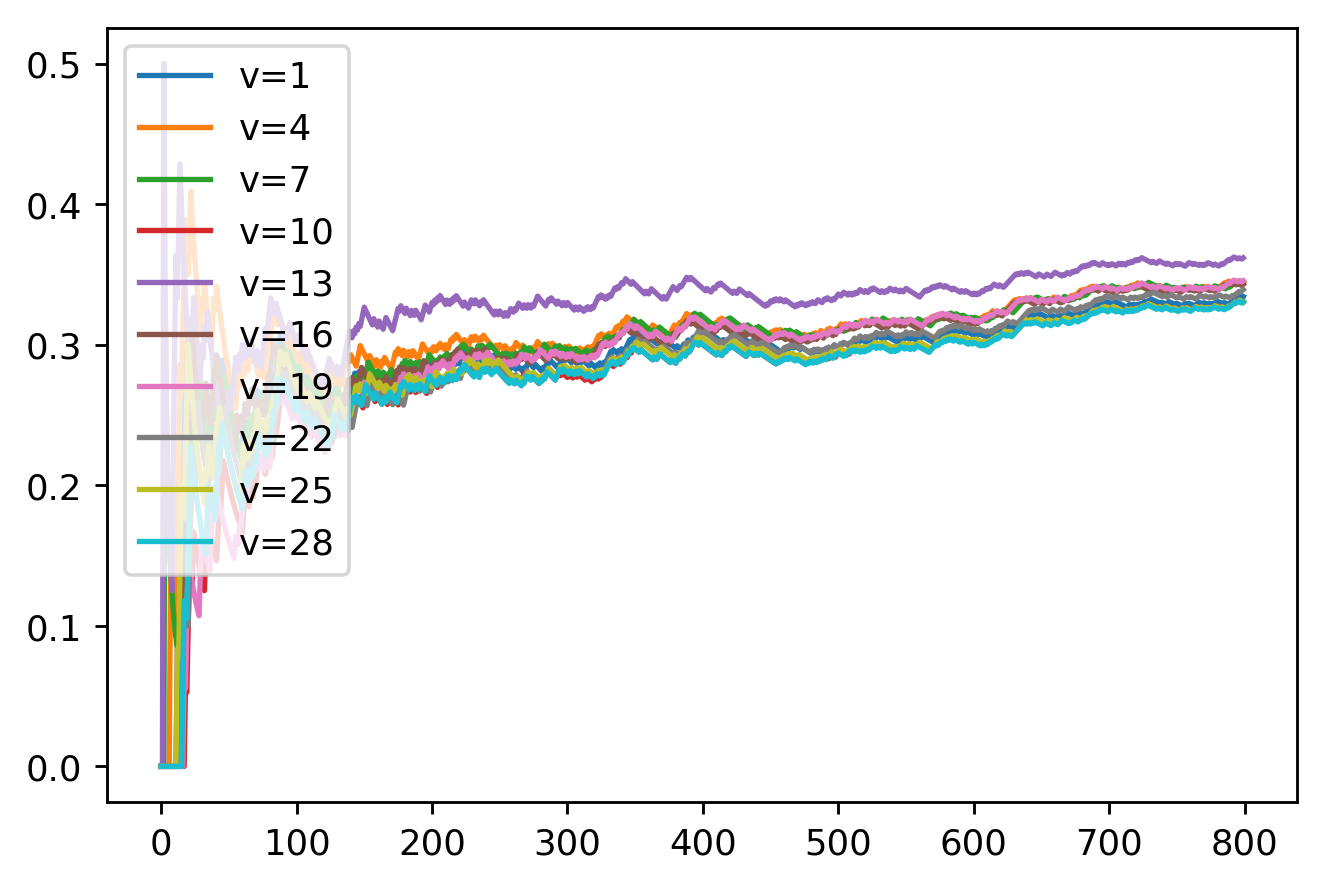

"\nExtremely high value such as 28 and extrenely low value such as 1 both underperforms\nThe value of 'v' varies\n\n"

In [90]:
FIGURE_RESOLUTION = 256
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
for v in np.arange(1,30,3):
    mab = LinThompson(10, 10, v)
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
    cresults_LinThompson = np.zeros(len(cresults_LinThompson))
    cresults_LinThompson[0] = results_LinThompson[0]
    for i in range(len(cresults_LinThompson)-1):
        cresults_LinThompson[i+1] = (cresults_LinThompson[i] * i + results_LinThompson[i+1])/(i+1)
    plt.plot(range(len(cresults_LinThompson)), cresults_LinThompson,label='v='+str(v))

plt.legend()
plt.show()


"""
Extremely high value such as 28 and extrenely low value such as 1 both underperforms
The value of 'v' is higher in somewhat middle. 
"""